**MODULACIÓN PAM**

Dada un secuencia de bits bcT almancenando cada bit en un arreglo, se procederá a realizar modulación PAM con M = 4

La secuencia de entrada es: [0 1 0 1 1 0 1]


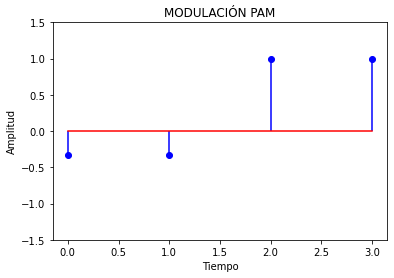

La secuencia modulada x(k):  [-0.33333333 -0.33333333  1.          1.        ]
La secuencia de bits demodulada:  [0 1 0 1 1 0 1 0]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
M = 4 



def modulacionPAM(bc):
    # Verificar que la longitud de la secuencia de bits bc(ℓ) sea múltiplo de log2(M)
    b = int(np.log2(M))
    if len(bc) % b != 0:
        # Rellenar con ceros si no es múltiplo
        bc = np.concatenate([bc, np.zeros(b - len(bc) % b)])

    # Dividir la secuencia de bits en grupos de M
    grupos = [bc[i:i+int(np.log2(M))] for i in range(0, len(bc), int(np.log2(M)))]
    #print(grupos)

    # Diccionario de asignación de símbolos de amplitud
    simbolos = {
        (0, 0): -1,
        (0, 1): -1/3,
        (1, 0): 1,
        (1, 1): 1/3
        }
    
    #Señal Modulada 
    x_k = []
    for señal in grupos:
        t_señal = tuple(señal)
        simbolo = simbolos[tuple(t_señal)]
        x_k.append(simbolo)
    x_k = np.array(x_k)

    #Definimos el tren de pulsos de amplitud 1 y longitud 20
    t = np.arange(0,len(x_k),1)
    p = np.ones_like(t)
    #print(t)
    x_k = x_k*p
    #print(x_k)

    # Graficar el tren de pulsos
    plt.stem(t, x_k, linefmt='b-', markerfmt='bo', basefmt='r-')

    # Configurar etiquetas y título del gráfico
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.title('MODULACIÓN PAM')

    # Ajustar los límites del eje y
    plt.ylim(-1.5, 1.5)
    plt.show()

    return x_k
    

################################################




def demodulacionPAM(x_k):
    # Diccionario inverso de asignación de símbolos de amplitud
    simbolos_inversos = {
        -1: (0, 0),
        -1/3: (0, 1),
        1: (1, 0),
        1/3: (1, 1)
    }
    
    # Lista para almacenar la secuencia de bits demodulada
    bits_demodulados = []
    
    # Iterar sobre cada símbolo de amplitud en la secuencia modulada
    for simbolo in x_k:
        # Buscar el símbolo de amplitud correspondiente en el diccionario inverso
        bits = simbolos_inversos[simbolo]
        
        # Agregar los bits a la secuencia demodulada
        bits_demodulados.extend(bits)
    
    # Ajustar la longitud de la secuencia demodulada
    bits_demodulados = bits_demodulados[:len(x_k) * int(np.log2(M))]
    
    # Convertir la lista de bits demodulados en un array numpy
    bits_demodulados = np.array(bits_demodulados)
    
    return bits_demodulados



    
###############################################   
    

    
    
bcT = np.array([0,1,0,1,1,0,1])
print("La secuencia de entrada es:",bcT)
x_k = modulacionPAM(bcT)
print("La secuencia modulada x(k): ", x_k)


bits_demodulados = demodulacionPAM(x_k)
print("La secuencia de bits demodulada: ", bits_demodulados)


**MEDIO DE TRANSMISIÓN RUIDOSO**

Simule un medio de transmisión ruidoso definiendo un ruido N
y almacenándola en una variable N. Escriba un programa que cambie aleatoriamente el valor de cada muestra de una secuencia de muestras transmitidos x(k), almacenada en un arreglo xT. Las muestras modificados deben conformar la secuencia de muestras recibidos  x∗(k), del mismo tamaño de x(k), almacenada en un arreglo xR.


In [3]:
def add_noise(x, snr):
    # Calcular la potencia de la señal transmitida
    signal_power = np.mean(np.abs(x) ** 2)

    # Calcular la potencia del ruido en función de la relación señal-ruido (SNR)
    noise_power = signal_power / (10 ** (snr / 10))

    # Generar el ruido gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(x))

    # Sumar el ruido a la señal transmitida
    x_r = x + noise

    return x_r

x_R = add_noise(x_k, 10)
print("Secuencia con ruido: ", x_R)

Secuencia con ruido:  [-0.28051167 -0.57894691  0.29616699 -1.22108793]


**Desmodulador digital banda-base**
Simule un desmodulador digital banda-base que utilice un esquema de modulación PAM de orden  M , definiendo un procedimiento de muestreo o de integración y descarte y escribiendo un programa que recupere los bits de una secuencia de información, almacenada en un arreglo a partir de una secuencia de muestras.


In [5]:
import numpy as np

def desmodulador_pam(xR, bcR, M, Ns, b):
    # Separar la secuencia de muestras en secuencias de longitud Ns
    xn = np.reshape(xR, (-1, Ns))

    # Realizar muestreo en k = Ns / 2 - 1 o promediar las muestras para obtener los valores recibidos yn
    yn = xn[:, int(Ns / 2) - 1]

    # Decodificar los símbolos recibidos a partir de los valores yn
    a_estimado = np.zeros_like(yn, dtype=np.uint8)    
    for i, y in enumerate(yn):
        a_estimado[i] = np.argmin(np.abs(y - bcR))

    # Ajustar la longitud de a_estimado si es necesario
    if len(a_estimado) > len(xR) // Ns:
        a_estimado = a_estimado[:len(xR) // Ns]

    # Construir la secuencia de bits recibidos a partir de los símbolos recibidos
    bits_recibidos = np.unpackbits(a_estimado).reshape(-1, b)

    # Retirar los ceros adicionales agregados durante la modulación
    bits_recibidos = bits_recibidos[:, :int(Ns / b)]

    return bits_recibidos.flatten()

# Parámetros
M = 4        # Orden de la modulación PAM
Ns = len(x_R)      # Longitud de cada secuencia de muestras

b = int(np.log2(M))        # Cantidad de bits por símbolo

# Desmodulación
bits_recibidos = desmodulador_pam(x_R, bcT, M, Ns, b)

print("Secuencia de bits recibidos:", bits_recibidos)

TypeError: Expected an input array of unsigned byte data type